# Experiments with Correlation Filters

In [ ]:
from google.colab import files
import cv2            # image input/outpuit
import matplotlib.pyplot as plt  # graphics
import numpy as np    # fft2()
import pylab

Path to lena image:
https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png

--2021-08-31 13:02:12--  https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘Lenna_(test_image).png.1’

Lenna_(test_image). 100%[===================>] 462.73K  --.-KB/s    in 0.06s   

2021-08-31 13:02:12 (8.01 MB/s) - ‘Lenna_(test_image).png.1’ saved [473831/473831]



Original size (512, 512)


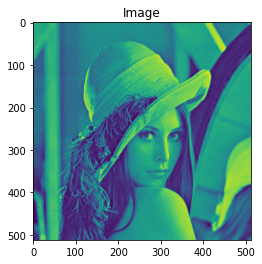

In [ ]:
# Read image as grayscale
img = cv2.imread('Lenna_(test_image).png', cv2.IMREAD_GRAYSCALE)
try:
  print('Original size',img.shape)
except AttributeError:
  print("shape not found")

# Display image
plt.imshow(img), plt.title('Image')
#plt.xticks([]), plt.yticks([])
plt.show()

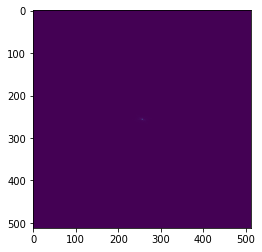

In [ ]:
imgFFT = np.fft.fft2(img)
#plt.imshow(abs(imgFFT)), plt.title('Image'), plt.show()
imgFFT = np.fft.fftshift(imgFFT)
pylab.imshow(np.abs(imgFFT))
pylab.show()

In [ ]:
print(imgFFT[1:5,1:5])

[[ -792.66123652-333.3653231j    126.64742675+212.05643861j
  -1516.59231176+221.69097153j  -104.39019766+916.31696251j]
 [ -172.70345732 +67.34381935j    98.04022571-455.60786435j
    571.37349808-512.42910431j  -997.30133572-671.81417539j]
 [  -56.28009035+545.53025244j   637.48888731+222.26133121j
    -59.35337953-571.08001001j  -101.80599867-217.78063616j]
 [ -263.113304  +312.52437918j   -89.74642833 +47.56021324j
    542.20100656-665.49512168j  -304.29977861-397.17666856j]]


Добавляем более продвинутую функцию для визуализации преобразования Фурье

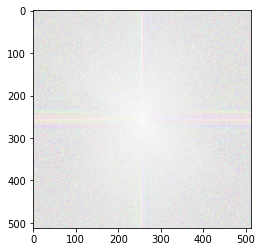

In [ ]:
from colorsys import hls_to_rgb
from numpy import pi

def colorize(z):
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + pi)  / (2 * pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c

cimgFFT = colorize(imgFFT)
pylab.imshow(cimgFFT)
pylab.show()

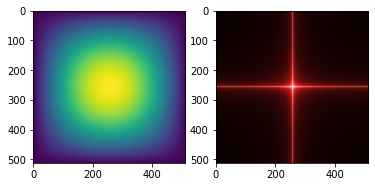

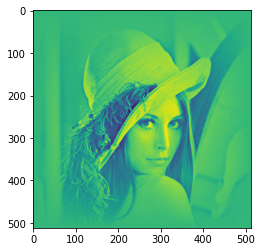

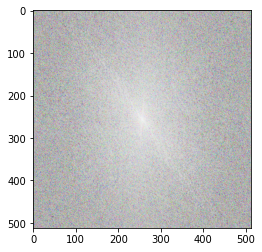

In [ ]:
def sin2d(x, y):
  wx = np.pi / x.shape[0]
  wy = np.pi / x.shape[1]
  #return np.minimum(np.sin(wx * x), np.sin(wy * y))
  return np.sin(wx * x) * np.sin(wy * y)

def sin2dwin(z):
  # Apply sine window
  #print('z.shape = ', z.shape)
  xaxis = np.arange(z.shape[0])
  yaxis = np.arange(z.shape[1])
  x, y = np.meshgrid(xaxis, yaxis)
  return sin2d(x, y)

def preprocess(inputim, verbose = False):
  inputim32f = inputim.astype('float32')
  if verbose:
    print('Initial values:\n', inputim32f[0:5, 0:5])

  # Logarithm to encrease sensitivity to dark shades
  procim = np.log(1 + inputim32f)
  if verbose:
    print('Logarithm values:\n', procim[0:5, 0:5])

  # Normalization to zero mean and singular std
  mu = np.mean(procim)
  sigma = np.std(procim - mu)
  procim = (procim - mu) / sigma
  if verbose:
    print('Normalized values:\n', procim[0:5, 0:5])
    print('std = ', np.std(procim), ' mean = ', np.mean(procim))

  # Apply sine window
  window = sin2dwin(procim)
  resultim = window * procim
  if verbose:
    print('Resulting values:\n', resultim[0:5, 0:5])
  return resultim, window

imgPreproc, window = preprocess(img)

# Visualize window and its spectrum
pylab.clf();
pylab.subplot(121)
pylab.imshow(window)
imgFFT = np.fft.fft2(window)
imgFFT = np.fft.fftshift(imgFFT)
cimgFFT = colorize(imgFFT)
pylab.subplot(122)
pylab.imshow(cimgFFT)
pylab.show()

# Visualize windowed image and its spectrum
pylab.imshow(imgPreproc)
pylab.show()
imgFFT = np.fft.fft2(imgPreproc)
imgFFT = np.fft.fftshift(imgFFT)
cimgFFT = colorize(imgFFT)
pylab.imshow(cimgFFT)
pylab.show()


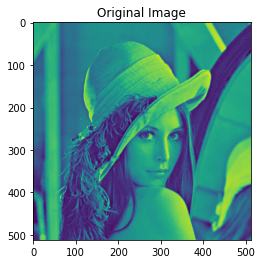

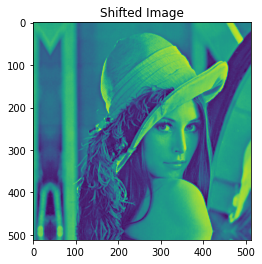

In [ ]:
def imshift(image, shift):
  dx = shift[0]
  dy = shift[1]
  mapmat = np.array([[1, 0, dx], [0, 1, dy]], dtype = 'float32')
  result = cv2.warpAffine(image, mapmat, image.shape, 
    flags=cv2.INTER_LINEAR+cv2.WARP_FILL_OUTLIERS, 
    borderMode = cv2.BORDER_REFLECT_101) #, mapmat)
  return result

# Produce a displacement of image
Shift = np.array([40, -20])
imgShifted = imshift(img, Shift)

# Display original image
plt.imshow(img), plt.title('Original Image')
plt.show()

# Display displaced image
plt.imshow(imgShifted), plt.title('Shifted Image')
plt.show()

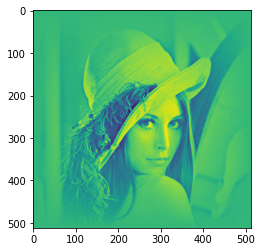

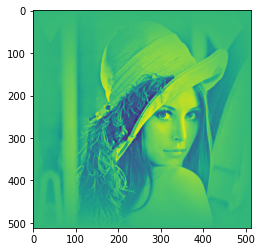

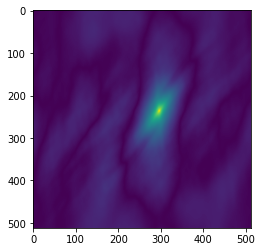

shiftValue.dx =  40.0
shiftValue.dy =  -20.0


In [ ]:
# Apply preprocess and FFT to original and displaced images
originPreproc, _ = preprocess(img)
originFFT = np.fft.fft2(originPreproc)
pylab.imshow(originPreproc)
pylab.show()

shiftedPreproc, _ = preprocess(imgShifted)
shiftedFFT = np.fft.fft2(shiftedPreproc)
pylab.imshow(shiftedPreproc)
pylab.show()

correlFFT = shiftedFFT * np.conj(originFFT)
correl = np.fft.ifft2(correlFFT)
correlView = abs(np.fft.fftshift(correl))
#print('correl.shape = ', correl.shape, ' correl.dtype = ', correl.dtype)

# Display correlation result
pylab.imshow(correlView) #, plt.title('Correlation')
pylab.show()

# Determine the coordinates of extremum
shiftEndPt = np.unravel_index(correlView.argmax(), correlView.shape)
shiftStartPt = 0.5 * np.array(correlView.shape)
shiftDisp = shiftEndPt - shiftStartPt
print('shiftValue.dx = ', shiftDisp[1])
print('shiftValue.dy = ', shiftDisp[0])

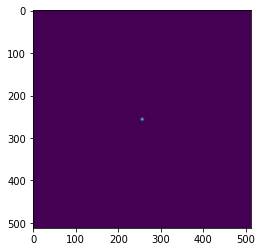

In [ ]:
# Generate g as gaussian with center of the object and sigma = 2.0
def gen_filter_output(center, imsize):
  xaxis = np.arange(imsize[0])
  yaxis = np.arange(imsize[1])
  x, y = np.meshgrid(xaxis, yaxis)
  sigma = 2.0
  norm1 = 1 / np.sqrt(2*np.pi*sigma)
  norm2 = 1 / (2 * sigma * sigma)
  output = norm1 * np.exp(-(np.square(x-center[0]) + np.square(y-center[1]))*norm2)
  return output

imsize = np.array(img.shape)
center = 0.5 * imsize
filt = gen_filter_output(center, imsize)
pylab.imshow(filt)
pylab.show()